In [28]:
import pandas as pd
import pyterrier as pt
import string
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from pyterrier.measures import *
from matplotlib import pyplot as plt
import re
import numpy as np

In [2]:
BASE_IDX = "indexes/stopwords_removed"
QUERIES = "data/train_queries.csv"
QRELS   = "data/train_qrels.csv"

# Load queries and qrels
qs = pd.read_csv(QUERIES, sep="\t", names=["qid", "query"], header=0)
qrels = pd.read_csv(QRELS, sep="\t")

# Strip out all punctuation
qs['query'] = qs['query'].str.replace(rf"[{re.escape(string.punctuation)}]", " ", regex=True)

# # Make the qid an str
qs['qid'] = qs['qid'].astype(str)
qrels['qid'] = qrels['qid'].astype(str)


train_qs, val_qs = train_test_split(
    qs,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# now get the corresponding qrels
train_qids = set(train_qs['qid'])
val_qids   = set(val_qs  ['qid'])

train_qrels = qrels[qrels['qid'].isin(train_qids)]
val_qrels   = qrels[qrels['qid'].isin(val_qids)]

In [3]:
stopwords_idx = pt.IndexFactory.of("./indexes/stopwords_removed")
stopwords_stemming_idx = pt.IndexFactory.of("./indexes/stopwords_and_stemming")
bm25 = pt.terrier.Retriever(stopwords_idx, wmodel="BM25", controls={"bm25.k_1": 3.5, "bm25.b": 0.75})
lmd = pt.terrier.Retriever(stopwords_stemming_idx, wmodel="DirichletLM", controls={"dirichletlm.mu": 100})

Java started (triggered by IndexFactory.of) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


In [44]:
from table_helpers import compute_ci

terms_list    = [10, 20, 40, 80]
fb_docs_fixed = 3

metrics_by_terms = {
    "BM25": { "means": [], "cis": [] },
    "LMD":  { "means": [], "cis": [] }
}

for fb_terms in tqdm(terms_list, desc="fb_terms loop"):
    # ---- BM25 + RM3 ----
    rm3_bm = pt.rewrite.RM3(stopwords_idx, fb_terms=fb_terms, fb_docs=fb_docs_fixed)
    pipe_bm = bm25 >> rm3_bm >> bm25
    rm3_lm = pt.rewrite.RM3(stopwords_stemming_idx, fb_terms=fb_terms, fb_docs=fb_docs_fixed)
    pipe_lm = lmd >> rm3_lm >> lmd

    result_df = pt.Experiment(
        [pipe_bm, pipe_lm], val_qs, val_qrels,
        eval_metrics=[RR@20],
        filter_by_qrels=True,
        verbose=False,
        perquery=True,
        names=["BM25", "LMD"]
    )
    ci_df = compute_ci(result_df)

    for _, row in ci_df.iterrows():
        model = row["name"]
        metrics_by_terms[model]["means"].append(row["mean"])
        metrics_by_terms[model]["cis"].append(row["ci"])


fb_terms loop:   0%|          | 0/4 [00:00<?, ?it/s]

In [45]:
fb_terms_fixed = 10
docs_list      = [1, 3, 5, 10, 20]

metrics_by_docs = {
    "BM25": { "means": [], "cis": [] },
    "LMD":  { "means": [], "cis": [] }
}

for fb_docs in tqdm(docs_list, desc="fb_docs loop"):
    # ---- BM25 + RM3 ----
    rm3_bm = pt.rewrite.RM3(stopwords_idx, fb_terms=fb_terms_fixed, fb_docs=fb_docs)
    pipe_bm = bm25 >> rm3_bm >> bm25

    # ---- LMD + RM3 ----
    rm3_lm = pt.rewrite.RM3(stopwords_stemming_idx, fb_terms=fb_terms_fixed, fb_docs=fb_docs)
    pipe_lm = lmd >> rm3_lm >> lmd

    result_df = pt.Experiment(
        [pipe_bm, pipe_lm],
        val_qs,
        val_qrels,
        eval_metrics=[RR@20],
        filter_by_qrels=True,
        verbose=False,
        perquery=True,
        names=["BM25", "LMD"]
    )

    ci_df = compute_ci(result_df)

    for _, row in ci_df.iterrows():
        model = row["name"]
        metrics_by_docs[model]["means"].append(row["mean"])
        metrics_by_docs[model]["cis"].append(row["ci"])

fb_docs loop:   0%|          | 0/5 [00:00<?, ?it/s]

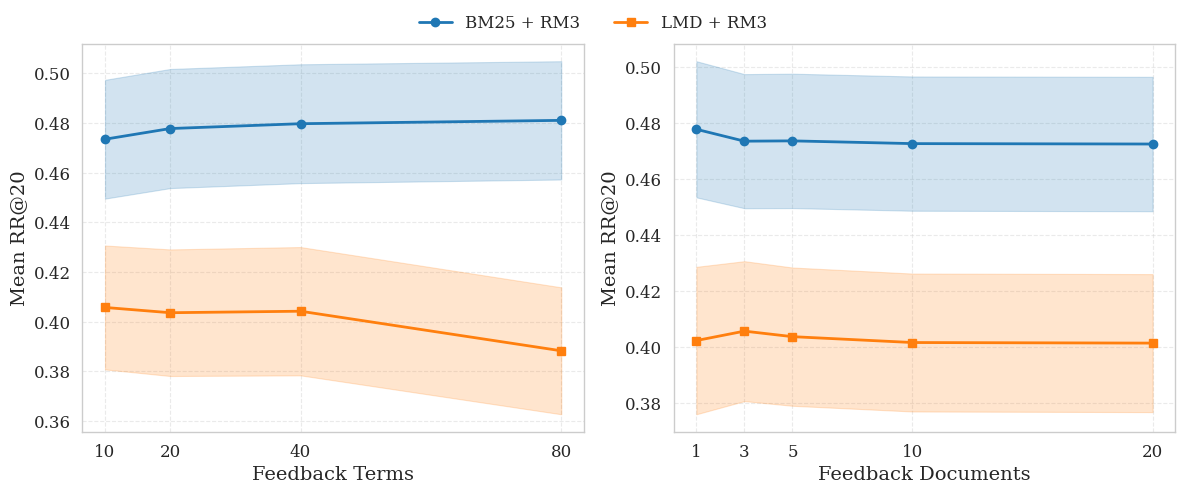

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: vary fb_terms with shaded 95% CI ---
bm_means_t = metrics_by_terms["BM25"]["means"]
bm_cis_t   = metrics_by_terms["BM25"]["cis"]
lm_means_t = metrics_by_terms["LMD"]["means"]
lm_cis_t   = metrics_by_terms["LMD"]["cis"]

# BM25 + RM3: line + fill
axes[0].plot(
    terms_list,
    bm_means_t,
    marker='o',
    linewidth=2,
    markersize=6,
    label='BM25 + RM3',
    color='C0'
)
axes[0].fill_between(
    terms_list,
    np.array(bm_means_t) - np.array(bm_cis_t),
    np.array(bm_means_t) + np.array(bm_cis_t),
    color='C0',
    alpha=0.2
)

# LMD + RM3: line + fill
axes[0].plot(
    terms_list,
    lm_means_t,
    marker='s',
    linewidth=2,
    markersize=6,
    label='LMD + RM3',
    color='C1'
)
axes[0].fill_between(
    terms_list,
    np.array(lm_means_t) - np.array(lm_cis_t),
    np.array(lm_means_t) + np.array(lm_cis_t),
    color='C1',
    alpha=0.2
)

axes[0].set_xlabel('Feedback Terms', fontsize=14)
axes[0].set_ylabel('Mean RR@20', fontsize=14)
axes[0].set_xticks(terms_list)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(True, linestyle='--', alpha=0.4)

# --- Right: vary fb_docs with shaded 95% CI ---
bm_means_d = metrics_by_docs["BM25"]["means"]
bm_cis_d   = metrics_by_docs["BM25"]["cis"]
lm_means_d = metrics_by_docs["LMD"]["means"]
lm_cis_d   = metrics_by_docs["LMD"]["cis"]

# BM25 + RM3: line + fill
axes[1].plot(
    docs_list,
    bm_means_d,
    marker='o',
    linewidth=2,
    markersize=6,
    label='BM25 + RM3',
    color='C0'
)
axes[1].fill_between(
    docs_list,
    np.array(bm_means_d) - np.array(bm_cis_d),
    np.array(bm_means_d) + np.array(bm_cis_d),
    color='C0',
    alpha=0.2
)

# LMD + RM3: line + fill
axes[1].plot(
    docs_list,
    lm_means_d,
    marker='s',
    linewidth=2,
    markersize=6,
    label='LMD + RM3',
    color='C1'
)
axes[1].fill_between(
    docs_list,
    np.array(lm_means_d) - np.array(lm_cis_d),
    np.array(lm_means_d) + np.array(lm_cis_d),
    color='C1',
    alpha=0.2
)

axes[1].set_xlabel('Feedback Documents', fontsize=14)
axes[1].set_ylabel('Mean RR@20', fontsize=14)
axes[1].set_xticks(docs_list)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(True, linestyle='--', alpha=0.4)

# Single legend at the top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=2,
    frameon=False,
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
